# TAR: Taller de Aprendizaje por Refuerzo 2025
## Laboratorio 4: Introdución a Gymnasium
### ¿Qué es Gymnasium?

**Gymnasium** es una librería ampliamente utilizada en el campo del aprendizaje por refuerzos. Proporciona una colección de entornos estandarizados, como simulaciones de juegos, tareas físicas y otros desafíos, que nos permiten evaluar y entrenar agentes en una variedad de escenarios. La simplicidad y flexibilidad de Gymnasium lo convierten en una herramienta ampliamente utilizada. Documentación https://gymnasium.farama.org/index.html

*Ejecutar esta celda solo la primera vez (si estan usando un entorno local) para descargar e instalar los paquetes necesarios. Si ejecutan el notebook en colab tendran que ejecutarla cada vez que reinicien el kernel*

#### IMPORTS

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Ejercicio 1. Frozen lake

En este ejercicio nos enfrentamos al problema de [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/), donde el agente aprenderá a navegar desde el **estado inicial (S)** hasta una **meta (G)**, evadiendo los **agujeros (H)** y caminando solamente sobre los bloques de **hielo (F)**.

Podemos tener dos tamaños de entorno:
- map_name="4x4": una versión de cuadrícula 4x4
- map_name="8x8": una versión de cuadrícula 8x8


El entorno tiene dos modos:
- is_slippery=False: El agente siempre se mueve en la dirección deseada  (determinístico).
- is_slippery=True: El agente puede no moverse siempre en la dirección deseada debido al hielo resbaladizo (estocástico).

Trabajaremos con la versión 8x8, y determinística.

### Implementaremos un agente basado en Q-learning
¿Que tipo de metodo es este?

##### RESPUESTA
Q-learning es un método de aprendizaje por refuerzo **libre de modelo** (model-free) y **fuera de política** (off-policy).

- **Libre de modelo**: No requiere conocer la función de transición del entorno ni la función de recompensa
- **Fuera de política**: Utiliza una política para explorar (ε-greedy) y otra para actualizar los valores Q (greedy)

El algoritmo aprende directamente los valores Q(s,a) que representan la utilidad esperada de tomar la acción 'a' en el estado 's' y seguir la política óptima a partir de ahí.

#### 1.1 Definir el ambiente.

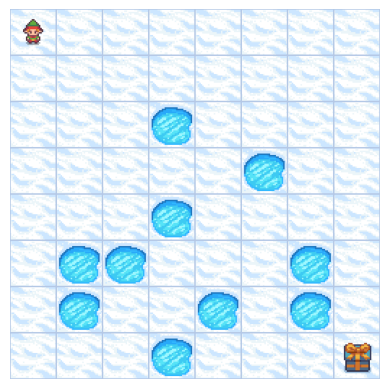

Hay  64  estados posibles
Hay  4  acciones posibles


In [2]:
#TODO Definir el ambiente `FrozenLake-v1` y renderizarlo en modo rgb_array
env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=False, render_mode="rgb_array")

# Reiniciar el entorno y renderizar la imagen inicial
env.reset()
image = env.render()

# Mostrar la imagen del entorno con matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()

#TODO Imprimir la cantidad de posibles estados y la cantidad de acciones posibles
state_space = env.observation_space.n
print("Hay ", state_space, " estados posibles")

action_space = env.action_space.n
print("Hay ", action_space, " acciones posibles")

Cada uno de los estados es representado por un entero, de izquierda a derecha y de arriba a abajo. El estado inicial es $S = [0,0]$ y el estado final $G = [7,7]$.

El espacio de acciones es discreto, con 4 acciones disponibles:
- 0: Mover izquierda
- 1: Mover abajo
- 2: Mover derecha
- 3: Mover arriba

Función de recompensa:
- 1 si llega a G, 0 por cualquier otro cambio de estado

### Definición de las políticas de decisión

Como Q-learning es un algoritmo off-policy, se utiliza una política de decisión para actuar y otra diferente para actualizar la tabla Q.
Se utilizarán:
- Política greedy (política de actualización)
- Política epsilon-greedy (política de actuación)

#### 1.2 Crear una función que implemente la política greedy. Las entradas son la tabla Q y el estado actual, y la salida es la acción a tomar.

In [3]:
# TODO crear una funcion que implemente la politica greedy.
def greedy_policy(Q, s):
    """
    Implementa la política greedy que selecciona la acción con el mayor valor Q.
    
    Args:
        Q: Tabla Q (matriz de estados x acciones)
        s: Estado actual (entero)
    
    Returns:
        Acción con el mayor valor Q para el estado s
    """
    return np.argmax(Q[s])

#### 1.3 Crear otra función que implemente la política epsilon-greedy. 
Además de los parámetros de entrada de la función anterior, agregar $ϵ$, que es la variable que controla la relación exploración/explotación a la hora de decidir que acción tomar.

In [4]:
def epsilon_greedy_policy(Q, s, epsilon):
    """
    Implementa la política epsilon-greedy que balancea exploración y explotación.
    
    Args:
        Q: Tabla Q (matriz de estados x acciones)
        s: Estado actual (entero)
        epsilon: Probabilidad de exploración (0 <= epsilon <= 1)
    
    Returns:
        Acción seleccionada según la política epsilon-greedy
    """
    if np.random.random() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return greedy_policy(Q, s)


Una vez creadas las funciones anteriores, solamente falta crear la función de entrenamiento. La misma debe seguir el siguiente pseudo-código:

```
Para cada episodio en el total de episodios de entrenamiento:

Reducir epsilon (ya que necesitamos cada vez menos exploración)
Reiniciar el entorno

  Para cada paso en el máximo número de timesteps:
    Elegir la acción At utilizando la política epsilon-greedy
    Realizar la acción (a) y observar el nuevo estado (s') y la recompensa (r)
    Actualizar el valor de Q(s,a) usando la ecuación de Bellman
    Si el episodio ha terminado, finalizarlo

```

**Actualización de la Tabla Q**
  
La función de valor Q se actualiza utilizando la ecuación de Bellman:  
  
$$ Q(s, a) \leftarrow Q(s, a) + \alpha \left[ R + \gamma \max_{a'} Q(s', a') - Q(s, a) \right] $$
  
donde:  
- $ \alpha $ es la tasa de aprendizaje.  
- $ \gamma $ es el factor de descuento.  
- $ R $ es la recompensa recibida.  
- $ s' $ es el nuevo estado.  
- $ a' $ es la acción que maximiza el valor Q en el nuevo estado.

**Observación**: Es importante que la variable `epsilon` varie entre un valor máximo y mínimo, y que vaya decayendo de manera exponencial según el `decay_rate` y el número de episodio en el que se esté.

**Observación 2**: Almacenar la ganacia acumulada para cada episodio para poder graficar la evolución de entrenamiento

#### 1.4 Crear la función de entrenamiento

In [5]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, gamma, learning_rate, Qtable, shortest_path_reward = None):
    rewards = []
    epsilon = max_epsilon
    for episode in range(n_training_episodes):
        state = env.reset()[0]
        reward_acumulada = 0
        for step in range(max_steps):
            a = epsilon_greedy_policy(Qtable, state, epsilon)

            new_state, reward, done, truncated, _= env.step(a)

            Qtable[state,a] += learning_rate*(reward + gamma*np.max(Qtable[new_state]) - Qtable[state, a])

            if shortest_path_reward:
                reward += shortest_path_reward
            reward_acumulada += reward
            state =  new_state

            if truncated or done:
                break
            
        epsilon = max(epsilon * (1 - decay_rate), min_epsilon)
        rewards.append(reward_acumulada)

    return Qtable, rewards

def predict(env, Qtable):
    state = env.reset()[0]
    steps_taken = 0
    while True:
        a = greedy_policy(Qtable, state)
        state, reward, done, truncated, _ = env.step(a)
        steps_taken += 1
        if done or truncated:
            break

    return reward, steps_taken


#### 1.5 Definir los hiperparámetros, inicializar la tabla Q llena de ceros y entrenar el agente

In [14]:
# Parámetros de entrenamiento
n_training_episodes = 100000  # Total de episodios de entrenamiento
learning_rate = 0.25  # Tasa de aprendizaje

# Parámetros del entorno
max_steps = 100  # Máximo de pasos por episodio
gamma = 0.5  # Tasa de descuento

# Parámetros de exploración
max_epsilon = 1  # Probabilidad de exploración al inicio
min_epsilon = 0.01  # Probabilidad mínima de exploración
decay_rate = 0.00005  # Tasa de decaimiento de epsilon

# inicializar la tabla Q con ceros
Qtable_frozenlake = np.zeros((env.observation_space.n, env.action_space.n))

In [15]:
Qtable_frozenlake, rewards = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, gamma, learning_rate, Qtable_frozenlake)

#### 1.6 El siguente código grafica el promedio de recompensas por cada bloque de 1000 episodios. Observar y explicar su comportamiento.

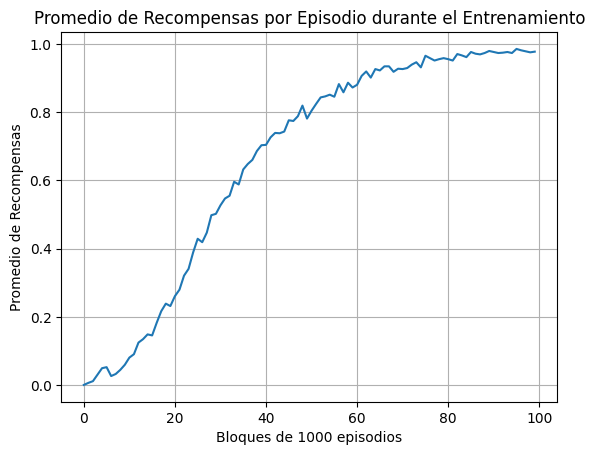

In [16]:
# Calculamos el promedio de recompensas por cada bloque de 1000 episodios
reward_per_thousand_episodes = np.split(np.array(rewards), n_training_episodes/1000)
count = 1000
avg_rewards = []

for r in reward_per_thousand_episodes:
    avg_rewards.append(sum(r/1000))
    count += 1000

# Visualizamos el promedio de recompensas
plt.plot(avg_rewards)
plt.xlabel('Bloques de 1000 episodios')
plt.ylabel('Promedio de Recompensas')
plt.title('Promedio de Recompensas por Episodio durante el Entrenamiento')
plt.grid()
plt.show()

#### 1.7 Simular un juego y obtener la ganancia (reward) total acumulada. Ver si el agente logró llegar a la meta (si el roward total es positivo).

En caso contrario variar los hiperparámetros.


In [17]:
total_reward = 0

total_reward, steps_taken = predict(env, Qtable_frozenlake)

if total_reward > 0:
    print(f'Llgegaste a la meta en {steps_taken} pasos!')
    print('total_reward ', total_reward)

Llgegaste a la meta en 14 pasos!
total_reward  1.0


#### 1.8 Qué impacto tiene en la solución obtenida los diferentes hiperparámetros? Qué sucede al variar el `decay_rate` y `max_epsilon` y `min_epsilon`?

Analizando Learning Rate...
Analizando Gamma...
Analizando Decay Rate...
Analizando Max Epsilon...
Analizando Min Epsilon...


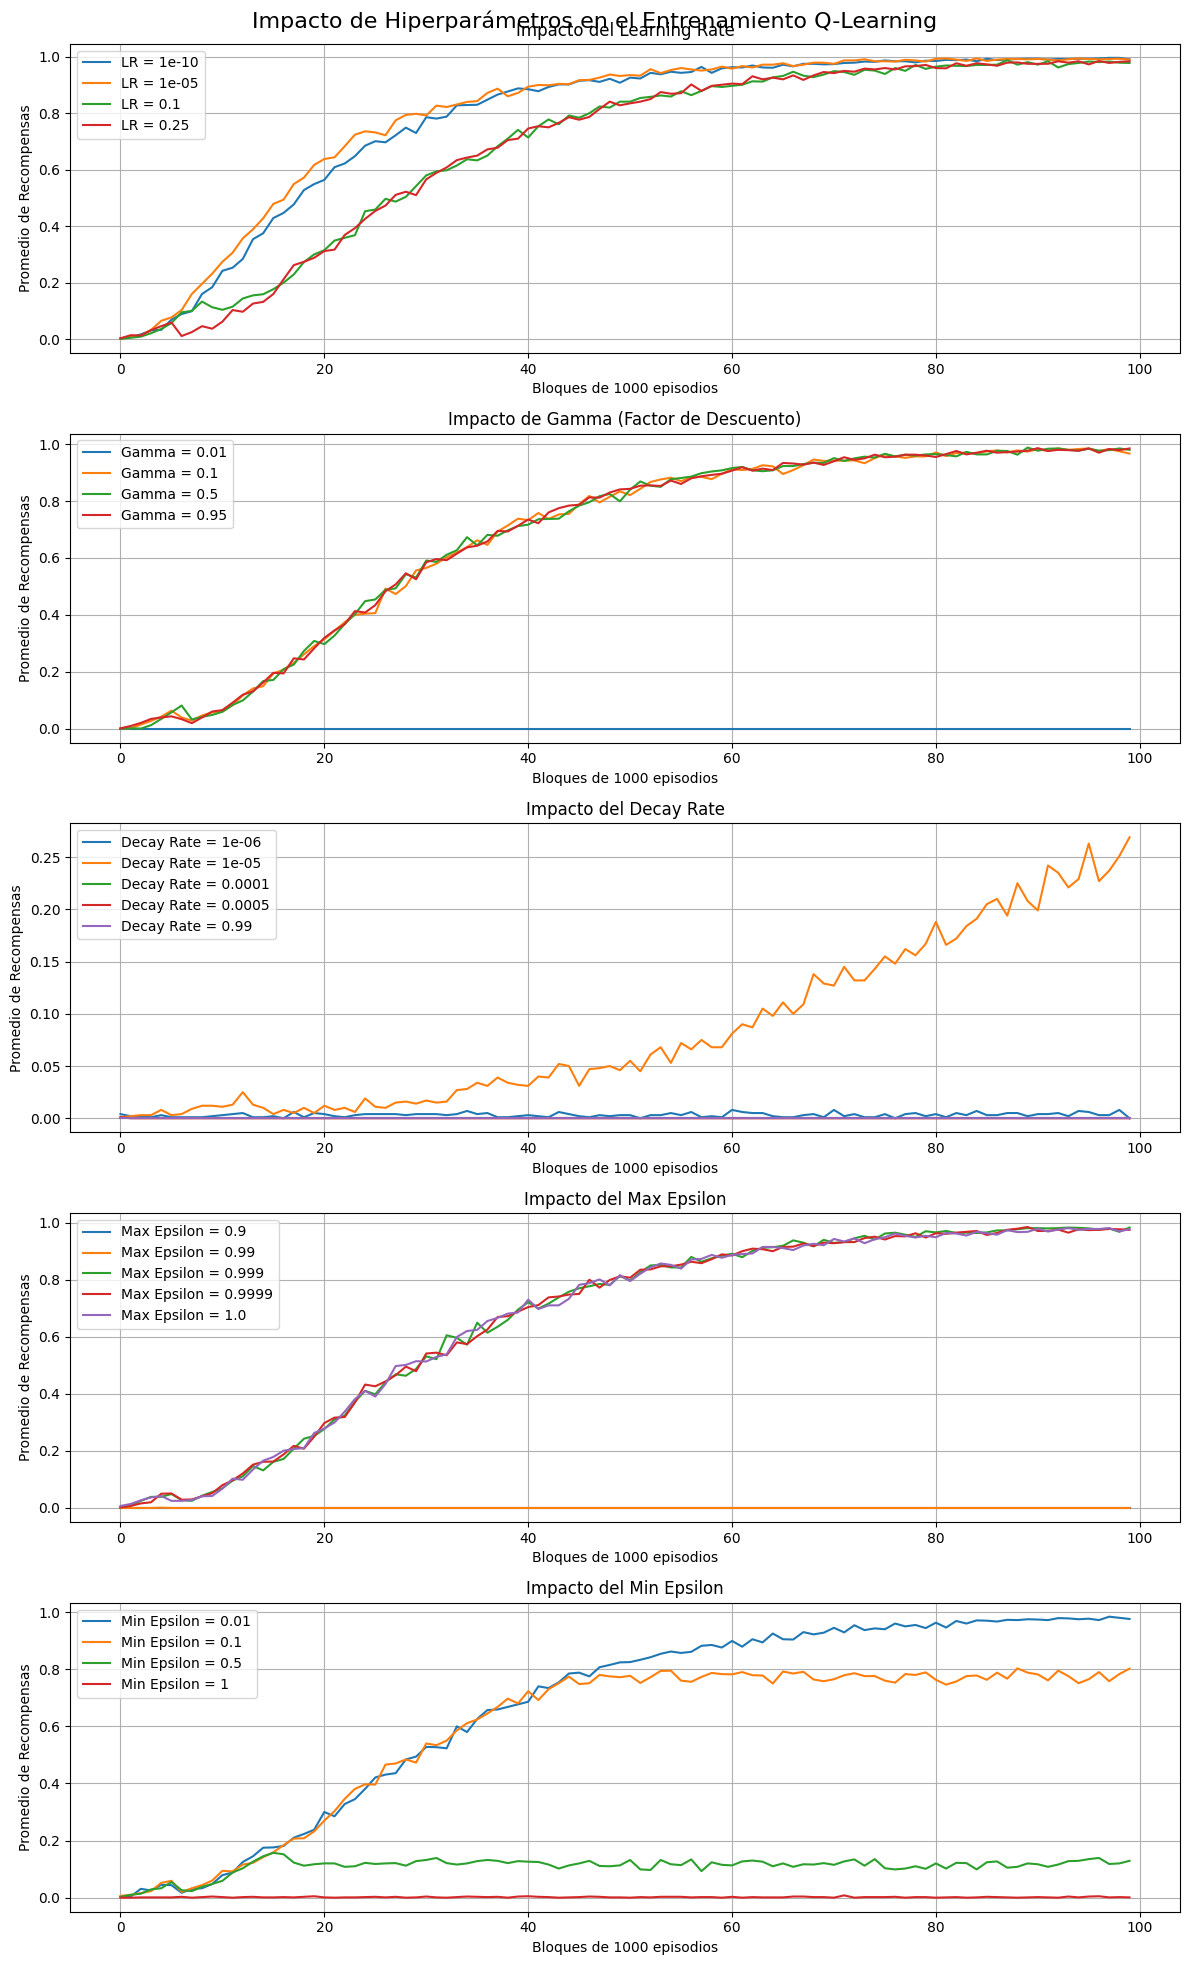

In [20]:
# Análisis del impacto de diferentes hiperparámetros

# Parámetros base
n_training_episodes = 100000
max_steps = 100

# Definir valores a probar para cada parámetro
learning_rates = [1e-10, 1e-5, 1e-1, 0.25]
gammas = [0.01, 0.1, 0.5, 0.95]
decay_rates = [1e-6, 1e-5, 1e-4, 5e-4, 0.99]
max_epsilons = [0.9,0.99, 0.999, 0.9999 ,1.0]
min_epsilons = [0.01, 0.1, 0.5 ,1]

# Parámetros fijos para cada experimento
base_learning_rate = 0.25
base_gamma = 0.5
base_decay_rate = 0.00005
base_max_epsilon = 1.0
base_min_epsilon = 0.01

# Crear subplots para mostrar los resultados
fig, axes = plt.subplots(5, 1, figsize=(12, 20))
fig.suptitle('Impacto de Hiperparámetros en el Entrenamiento Q-Learning', fontsize=16)

# 1. Análisis del Learning Rate
print("Analizando Learning Rate...")
for i, lr in enumerate(learning_rates):
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    _, rewards = train(
        n_training_episodes, base_min_epsilon, base_max_epsilon, base_decay_rate,
        env, max_steps, base_gamma, lr, Qtable
    )
    
    # Calcular promedio por bloques de 1000 episodios
    reward_blocks = np.split(np.array(rewards), n_training_episodes // 1000)
    avg_rewards = [np.mean(block) for block in reward_blocks]
    
    axes[0].plot(avg_rewards, label=f'LR = {lr}')

axes[0].set_title('Impacto del Learning Rate')
axes[0].set_xlabel('Bloques de 1000 episodios')
axes[0].set_ylabel('Promedio de Recompensas')
axes[0].legend()
axes[0].grid()

# 2. Análisis de Gamma
print("Analizando Gamma...")
for i, g in enumerate(gammas):
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    _, rewards = train(
        n_training_episodes, base_min_epsilon, base_max_epsilon, base_decay_rate,
        env, max_steps, g, base_learning_rate, Qtable
    )
    
    reward_blocks = np.split(np.array(rewards), n_training_episodes // 1000)
    avg_rewards = [np.mean(block) for block in reward_blocks]
    
    axes[1].plot(avg_rewards, label=f'Gamma = {g}')

axes[1].set_title('Impacto de Gamma (Factor de Descuento)')
axes[1].set_xlabel('Bloques de 1000 episodios')
axes[1].set_ylabel('Promedio de Recompensas')
axes[1].legend()
axes[1].grid()

# 3. Análisis del Decay Rate
print("Analizando Decay Rate...")
for i, dr in enumerate(decay_rates):
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    _, rewards = train(
        n_training_episodes, base_min_epsilon, base_max_epsilon, dr,
        env, max_steps, base_gamma, base_learning_rate, Qtable
    )
    
    reward_blocks = np.split(np.array(rewards), n_training_episodes // 1000)
    avg_rewards = [np.mean(block) for block in reward_blocks]
    
    axes[2].plot(avg_rewards, label=f'Decay Rate = {dr}')

axes[2].set_title('Impacto del Decay Rate')
axes[2].set_xlabel('Bloques de 1000 episodios')
axes[2].set_ylabel('Promedio de Recompensas')
axes[2].legend()
axes[2].grid()

# 4. Análisis del Max Epsilon
print("Analizando Max Epsilon...")
for i, me in enumerate(max_epsilons):
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    _, rewards = train(
        n_training_episodes, base_min_epsilon, me, base_decay_rate,
        env, max_steps, base_gamma, base_learning_rate, Qtable
    )
    
    reward_blocks = np.split(np.array(rewards), n_training_episodes // 1000)
    avg_rewards = [np.mean(block) for block in reward_blocks]
    
    axes[3].plot(avg_rewards, label=f'Max Epsilon = {me}')

axes[3].set_title('Impacto del Max Epsilon')
axes[3].set_xlabel('Bloques de 1000 episodios')
axes[3].set_ylabel('Promedio de Recompensas')
axes[3].legend()
axes[3].grid()

# 5. Análisis del Min Epsilon
print("Analizando Min Epsilon...")
for i, me in enumerate(min_epsilons):
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    _, rewards = train(
        n_training_episodes, me, base_max_epsilon, base_decay_rate,
        env, max_steps, base_gamma, base_learning_rate, Qtable
    )
    
    reward_blocks = np.split(np.array(rewards), n_training_episodes // 1000)
    avg_rewards = [np.mean(block) for block in reward_blocks]
    
    axes[4].plot(avg_rewards, label=f'Min Epsilon = {me}')

axes[4].set_title('Impacto del Min Epsilon')
axes[4].set_xlabel('Bloques de 1000 episodios')
axes[4].set_ylabel('Promedio de Recompensas')
axes[4].legend()
axes[4].grid()

plt.tight_layout()
plt.show()


##### RESPUESTA

**Análisis del Learning Rate:**
Respecto a la tasa de aprendizaje, se observa cómo a medida que ésta crece, el comportamiento inicial se vuelve más errático, incrementando el tiempo necesario para la convergencia. Sin embargo, eventualmente todos los valores terminan convergiendo a un comportamiento similar. Un learning rate alto hace que el agente actualice sus valores Q de manera más agresiva, lo que puede causar oscilaciones iniciales pero no necesariamente afecta el rendimiento final.

**Análisis del Factor de Descuento (Gamma):**
El factor de descuento tiene mayor relevancia en episodios largos donde las recompensas futuras son más importantes. En este entorno particular, los episodios son relativamente cortos, lo que reduce significativamente el impacto de este parámetro en el proceso de aprendizaje. Se observa que mientras el valor no sea excesivamente pequeño, el comportamiento del agente permanece consistente.

**Análisis del Decay Rate:**
Este parámetro controla qué tan rápido disminuye la exploración (epsilon) durante el entrenamiento. Cuando el decay rate es bajo, epsilon permanece alto durante períodos prolongados, manteniendo al modelo en modo exploración y retrasando la convergencia hacia una política óptima. Conversamente, si el decay rate es demasiado alto, el modelo abandona la exploración prematuramente, lo que puede impedir que descubra estrategias óptimas. Los resultados muestran que el modelo es particularmente sensible a la elección de este parámetro.

**Análisis de Max y Min Epsilon:**
Los valores límites de epsilon también juegan un papel crucial en el balance exploración-explotación. Si el epsilon inicial (max epsilon) es demasiado bajo, el modelo no explorará suficientemente el espacio de estados-acciones, limitando su capacidad para construir una buena tabla Q. Por otro lado, si el epsilon mínimo es excesivamente alto, el agente continuará explorando incluso después de haber aprendido una buena política, lo que puede degradar el rendimiento al no explotar adecuadamente el conocimiento adquirido.

#### 1.9 Si se quisiera un agente que tome el camino más corto, ¿qué solución/es se le ocurre? Implementarla/s

##### RESPUESTA -->

Una solucion facil es agregar una pequeña reward negativa en cada paso, forzando asi al model a aprender un camino mas corto

Llgegaste a la meta en 14 pasos!
total_reward  1.0


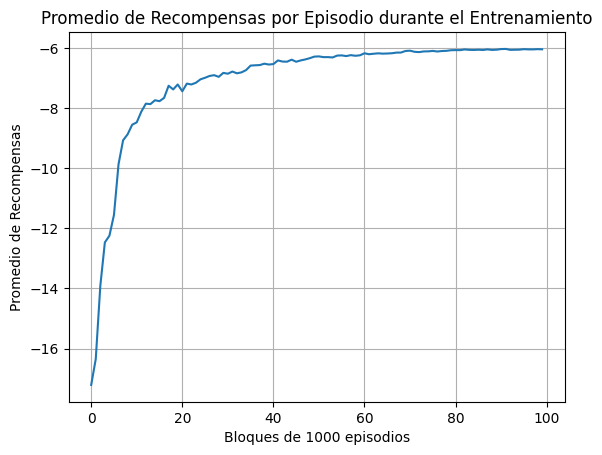

In [23]:
# Parámetros de entrenamiento
n_training_episodes = 100000  # Total de episodios de entrenamiento
learning_rate = 0.25  # Tasa de aprendizaje

# Parámetros del entorno
max_steps = 100  # Máximo de pasos por episodio
gamma = 0.5  # Tasa de descuento

# Parámetros de exploración
max_epsilon = 1  # Probabilidad de exploración al inicio
min_epsilon = 0.01  # Probabilidad mínima de exploración
decay_rate = 0.00005  # Tasa de decaimiento de epsilon

# inicializar la tabla Q con ceros
Qtable_frozenlake = np.zeros((env.observation_space.n, env.action_space.n))
Qtable_frozenlake, rewards = train(
    n_training_episodes,
    min_epsilon,
    max_epsilon,
    decay_rate,
    env,
    max_steps,
    gamma,
    learning_rate,
    Qtable_frozenlake,
    shortest_path_reward = -0.5
)

total_reward = 0

total_reward, steps_taken = predict(env, Qtable_frozenlake)

if total_reward > 0:
    print(f"Llgegaste a la meta en {steps_taken} pasos!")
    print("total_reward ", total_reward)

# Calculamos el promedio de recompensas por cada bloque de 1000 episodios
reward_per_thousand_episodes = np.split(np.array(rewards), n_training_episodes / 1000)
count = 1000
avg_rewards = []

for r in reward_per_thousand_episodes:
    avg_rewards.append(sum(r / 1000))
    count += 1000

# Visualizamos el promedio de recompensas
plt.plot(avg_rewards)
plt.xlabel("Bloques de 1000 episodios")
plt.ylabel("Promedio de Recompensas")
plt.title("Promedio de Recompensas por Episodio durante el Entrenamiento")
plt.grid()
plt.show()

En este caso, los parametros originales ya forzaban al modelo a aprender un camino mas corto, por lo que no fue necesario variar los parametros. Si se observa al agregar la reward negativa, el modelo converge mas rapido, ya que el objetivo es minimizar la penalidad.

La siguente función toma la tabla Q entrenada y simula un juego, guardando los frames y generando un video.

In [12]:
from matplotlib import animation
def generate_frames(q_table, env, max_steps=100):
    """Genera una lista de frames para crear la animación"""
    state, _ = env.reset()
    frames = [env.render()]  # Render del estado inicial
    for step in range(max_steps):
        action = greedy_policy(q_table, state)
        next_state, reward, done, _, _ = env.step(action)
        frames.append(env.render())  # Guardar el nuevo estado como frame

        state = next_state

        if done:
            break
    return frames

def save_video(frames, filename='q_learning_frozenlake.mp4'):
    """Guardar el video de los frames en un archivo .mp4"""
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=300)

    # Guardar animación
    anim.save(filename, writer='ffmpeg', fps=5)
    plt.close()

In [13]:
# # Generar los frames a partir de la tabla Q
# frames = generate_frames(Qtable_frozenlake, env)

# # Guardar el video
# save_video(frames)

## Ejercicio 2. Ta-te-ti usando Q-learning

En esta sección, vamos a entrenar un agente de aprendizaje por refuerzo utilizando el algoritmo de **Q-Learning** para jugar al juego de **Ta-Te-Ti**. El objetivo es que el agente aprenda a tomar decisiones óptimas en cada estado del juego para maximizar su recompensa y ganar la mayor cantidad de partidas posible.

En el archivo ta-te-ti_env.py se define el entorno del **Ta-Te-Ti** que utilizaremos para entrenar nuestro agente de Q-Learning. Buscamos crear un entorno compatible con las interfaces de Gym, lo que significa que debe incluir métodos como `reset`, `render`, `step`, así como propiedades como `observation_space` y `action_space`. Es importante leer y entender la definición del ambiente antes de continuar.

El entorno de **Ta-Te-Ti** consta de un tablero de $3\times3$, para el cual se utiliza un vector de $9$ valores para definir su estado. Este vector se rellena con valores $0$ para los lugares disponibles, con $1$ para  indicar las posiciones donde juega el agente y con $-1$ para indicar las posiciones del oponente.
El environment permite recibir como parámetros de inicialización los reward para el caso donde el agente gana, pierde o empata.

In [24]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from ta_te_ti_env import TaTeTiEnv, play_against_agent

env = TaTeTiEnv()

#### 2.1. Observar la cantidad de posibles estados y posibles acciones a tomar.

In [25]:
state_space = env.observation_space.n #....
print("Hay ", state_space, " estados posibles")

action_space = env.action_space.n
print("Hay ", action_space, " acciones posibles")

Hay  19683  estados posibles
Hay  9  acciones posibles


#### 2.2. Definir los hiperparámetros y entrenar el agente utilizando las mismas funciones creadas para la parte 2. Variar los diferentes hiperparámetros y diferentes rewards para mejorar la tabla Q obtenida.


Entrenando con configuración: Base
Learning Rate: 0.7, Gamma: 0.5, Decay Rate: 5e-05

Entrenando con configuración: LR Bajo
Learning Rate: 0.1, Gamma: 0.5, Decay Rate: 5e-05

Entrenando con configuración: LR Alto
Learning Rate: 0.9, Gamma: 0.5, Decay Rate: 5e-05

Entrenando con configuración: Gamma Bajo
Learning Rate: 0.7, Gamma: 0.1, Decay Rate: 5e-05

Entrenando con configuración: Gamma Alto
Learning Rate: 0.7, Gamma: 0.9, Decay Rate: 5e-05

Entrenando con configuración: Decay Rápido
Learning Rate: 0.7, Gamma: 0.5, Decay Rate: 0.0005

Entrenando con configuración: Decay Lento
Learning Rate: 0.7, Gamma: 0.5, Decay Rate: 5e-06


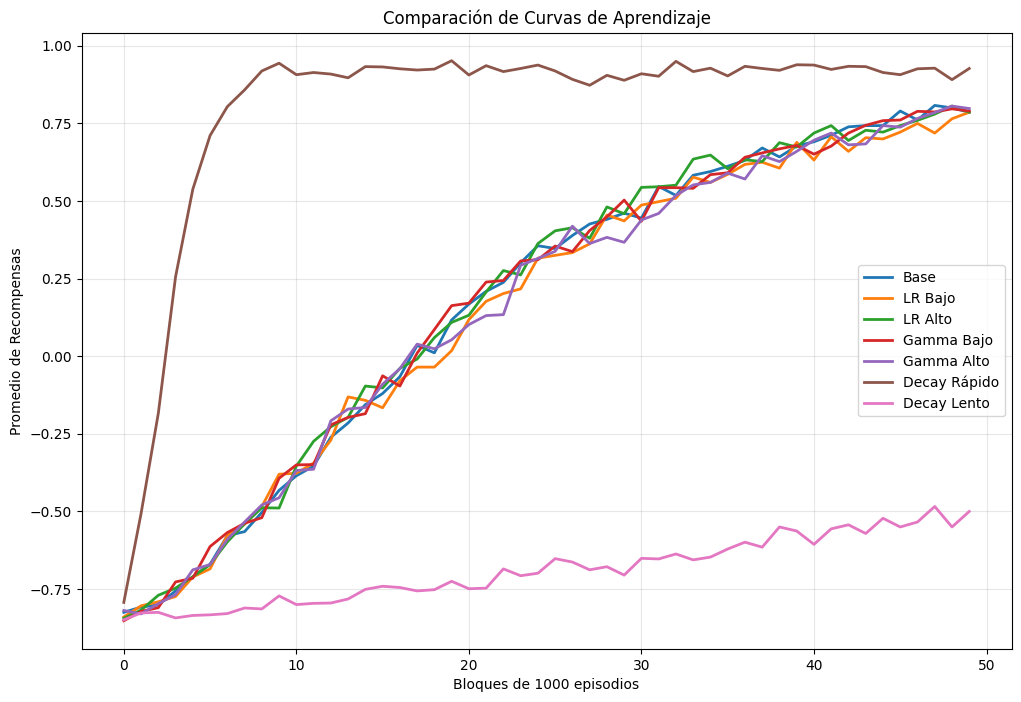


RESUMEN DE RESULTADOS
Base            | Recompensa Final: 0.786
LR Bajo         | Recompensa Final: 0.786
LR Alto         | Recompensa Final: 0.786
Gamma Bajo      | Recompensa Final: 0.790
Gamma Alto      | Recompensa Final: 0.798
Decay Rápido    | Recompensa Final: 0.927
Decay Lento     | Recompensa Final: -0.500

Mejor configuración: Decay Rápido


In [ ]:
# Experimentación con diferentes valores de parámetros
# Vamos a probar distintas configuraciones de decay_rate, learning_rate y gamma

# Configuraciones a probar
configs = [
    {"learning_rate": 0.7, "gamma": 0.5, "decay_rate": 0.00005, "name": "Base"},
    {"learning_rate": 0.1, "gamma": 0.5, "decay_rate": 0.00005, "name": "LR Bajo"},
    {"learning_rate": 0.9, "gamma": 0.5, "decay_rate": 0.00005, "name": "LR Alto"},
    {"learning_rate": 0.7, "gamma": 0.1, "decay_rate": 0.00005, "name": "Gamma Bajo"},
    {"learning_rate": 0.7, "gamma": 0.9, "decay_rate": 0.00005, "name": "Gamma Alto"},
    {"learning_rate": 0.7, "gamma": 0.5, "decay_rate": 0.0005, "name": "Decay Rápido"},
    {"learning_rate": 0.7, "gamma": 0.5, "decay_rate": 0.000005, "name": "Decay Lento"},
]

win_reward = 1
draw_reward = 0
loss_reward = -1
env = TaTeTiEnv(win_reward, draw_reward, loss_reward)

# Parámetros fijos
n_training_episodes = 50000
max_steps = 9
max_epsilon = 1
min_epsilon = 0.01
eval_seed = []

# Almacenar resultados
results = {}
all_avg_rewards = {}

# Entrenar con cada configuración
for config in configs:
    print(f"\nEntrenando con configuración: {config['name']}")
    print(f"Learning Rate: {config['learning_rate']}, Gamma: {config['gamma']}, Decay Rate: {config['decay_rate']}")
    
    Qtable = np.zeros((env.observation_space.n, env.action_space.n))
    
    Qtable_trained, rewards = train(
        n_training_episodes, 
        min_epsilon, 
        max_epsilon, 
        config['decay_rate'], 
        env, 
        max_steps, 
        config['learning_rate'], 
        config['gamma'], 
        Qtable
    )
    
    # Calcular promedio de recompensas por cada bloque de 1000 episodios
    reward_per_thousand_episodes = np.split(np.array(rewards), n_training_episodes / 1000)
    avg_rewards = []
    
    for r in reward_per_thousand_episodes:
        avg_rewards.append(sum(r / 1000))
    
    results[config['name']] = {
        'qtable': Qtable_trained,
        'final_avg_reward': avg_rewards[-1],
        'all_rewards': rewards
    }
    all_avg_rewards[config['name']] = avg_rewards

plt.figure(figsize=(12, 8))

for name, avg_rewards in all_avg_rewards.items():
    plt.plot(avg_rewards, label=name, linewidth=2)

plt.xlabel("Bloques de 1000 episodios")
plt.ylabel("Promedio de Recompensas")
plt.title("Comparación de Curvas de Aprendizaje")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*60)
print("RESUMEN DE RESULTADOS")
print("="*60)
for name, result in results.items():
    print(f"{name:15} | Recompensa Final: {result['final_avg_reward']:.3f}")


Similar al caso anterior, se observa que el modelo es robusto a muchas de las elecciones de parámetros. En este caso, se observa que el modelo converge más rápido con un decay rápido. Es decir, comenzar explorando más y disminuyendo la exploración para aumentar la explotación conforme pasa el tiempo.

#### 2.3 Jugar contra el agente, y observar donde y cuando falla. Ajustar hiperparámetros y rewards para mejorar su rendimiento

En particular, experimentar con distintos valores de recompensa. Es interesante visualizar que pasa para los casos donde la recompensa negativa (cuando el agente pierde) es más fuerte que para cuando gana.

In [40]:
win_reward = 1
draw_reward = -1
loss_reward = -10
env = TaTeTiEnv(win_reward, draw_reward, loss_reward)

Qtable = np.zeros((env.observation_space.n, env.action_space.n))

Qtable_trained, rewards = train(
    n_training_episodes * 10,
    min_epsilon,
    max_epsilon,
    0.00005,
    env,
    max_steps,
    0.7,
    0.5,
    Qtable,
)

In [42]:
play_against_agent(Qtable, env)

Bienvenido al ta te ti! Vos sos el jugador '1' y el agente es el '-1'.
[[0 0 0]
 [0 0 0]
 [0 0 0]]
Acciones disponibles: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Turno del agente. Agente juega la acción 5
[[ 0  0  0]
 [ 0  0 -1]
 [ 0  0  0]]
Acciones disponibles: [0, 1, 2, 3, 4, 6, 7, 8]
[[ 0  0  0]
 [ 0  1 -1]
 [ 0  0  0]]
Acciones disponibles: [0, 1, 2, 3, 6, 7, 8]
Turno del agente. Agente juega la acción 0
[[-1  0  0]
 [ 0  1 -1]
 [ 0  0  0]]
Acciones disponibles: [1, 2, 3, 6, 7, 8]
[[-1  0  0]
 [ 0  1 -1]
 [ 1  0  0]]
Acciones disponibles: [1, 2, 3, 7, 8]
Turno del agente. Agente juega la acción 2
[[-1  0 -1]
 [ 0  1 -1]
 [ 1  0  0]]
Acciones disponibles: [1, 3, 7, 8]
[[-1  0 -1]
 [ 0  1 -1]
 [ 1  0  1]]
Acciones disponibles: [1, 3, 7]
Turno del agente. Agente juega la acción 7
[[-1  0 -1]
 [ 0  1 -1]
 [ 1 -1  1]]
Acciones disponibles: [1, 3]
[[-1  1 -1]
 [ 0  1 -1]
 [ 1 -1  1]]
Acciones disponibles: [3]
Turno del agente. Agente juega la acción 3
[[-1  1 -1]
 [-1  1 -1]
 [ 1 -1  1]]
Empate!
Gam

Cuando la reward de perder es muy alta, el modelo parece no aprender a ganar, sino que intenta evitar perder, suele terminar en empate. El modelo en general parece ser mejor cuando empieza, lo cual es razonable ya que en el momento del entrenamiento siempre empieza el modelo.

Algo que me queda la duda es que el modelo aprende contra un oponente que juega aleatoriamente, es decir, el modelo no aprende a ganar contra un oponente que juega de manera óptima. Podría ser interesante entrenar dos modelos en simultaneo, uno contra el otro, y ver si el resultado final es mejor.